##                                                                                                                 Rossman Sales Prediction

##**Abstract**

The main aim of the notebook is to predict Sales price of various Store Types of Rossman.
The Dataset consists of various factors such as number of customers for each store,no of 1st promotion offered by the store,Number of Stores that offer 2nd promotion followed by 1st promotion,Effect of Sales due to School& State Holiday,distance of Competition Stores from the current store that effect the Sales of the store.

These factors are taken into consideration while forecasting  the sales price of Stores for 6 weeks.


Steps :                      
Data Cleansing:               
Removal of Null values                                                            
Creating new features                                           

Feature Selection:                                                         
Important features which are effecting the Sales are included for the prediction


2 Models are trained for analysing the predictions:
1) SARIMAX model  - The model could not provide an improvement of RMSPE below 1.0
2) XGBoost -  The model boosted the performance and led to the improvement of 

##**DataSet**
The dataset contains historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

Kaggle Link for the Dataset:https://www.kaggle.com/c/rossmann-store-sales/data

## Approach
1) Data Cleansing                   
2) Exploratory Data Analysis             
3) Feature Selection                        
4) Data Modelling : Model Training is done by parameter tunning through hyperparameter tunning



Import the libraries

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import os
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from pandas import DataFrame


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
from google.colab import drive

Upload the test,train and Store file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving store.csv to store.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "store.csv" with length 45010 bytes
User uploaded file "test.csv" with length 1427425 bytes
User uploaded file "train.csv" with length 38057952 bytes


In [0]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']),parse_dates=[2], low_memory = False)
test = pd.read_csv(io.BytesIO(uploaded['test.csv']),parse_dates=[3], low_memory = False)
store = pd.read_csv(io.BytesIO(uploaded['store.csv']),low_memory=False)

Check the train data

In [5]:
#train
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [6]:
#test
test.head().append(test.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [7]:
#store
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


##**Part 1-Exploratory Data Analysis**

check for NAN values in train , test and store data

In [8]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


Store having NAN values for CompetitionOpenSinceMonth

In [10]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


Store having NAN for Promo2SinceWeek

In [11]:
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

The dataset contains the values f Sales which are 0 due to School or State Holiday.              
Plot the train data having sales greater then 0 for Store1   
It can be seen the sales jumps during end of Decemeber each year

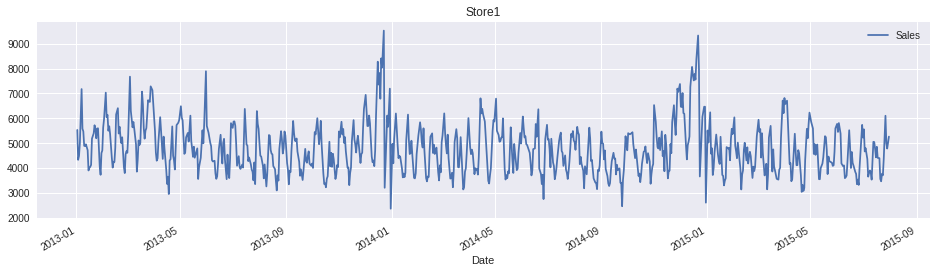

In [0]:
# sales of store1 full timne
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

Compare the Sles of Store 1 from 1st June 2016 to 31st July 2014 vs 1st August 2014 - 30th Sept 2014

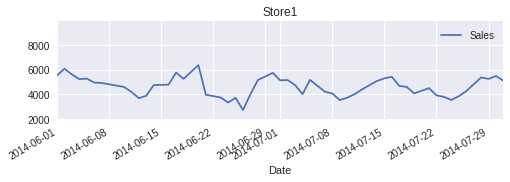

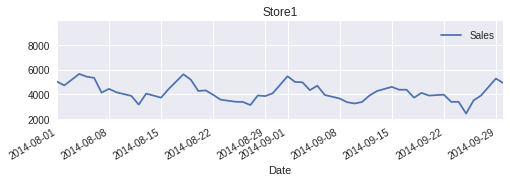

In [0]:
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

Fill the null values of test datset & Train dataset

In [0]:
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)

In [0]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

We can see all the null values are replaced and now we can moveahead with our analysis

In [14]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [0]:
train1 = train

In [16]:
train1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [17]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [0]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

## Part 2-Feature Creation / Feature Selection

Merge the training dataset with the Store dataset
Merge the Test dataset with store dataset

In [0]:
train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2['Sales/Customer'].describe()

df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [0]:

def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [22]:
features_create(df_train_store)
features_create(train2)
features_create(df_test_store)
print('Features creation finished')
# train.head()

Features creation finished


We can see that the Customers,promo, Open and Sales/Customers are highly correlated with sales

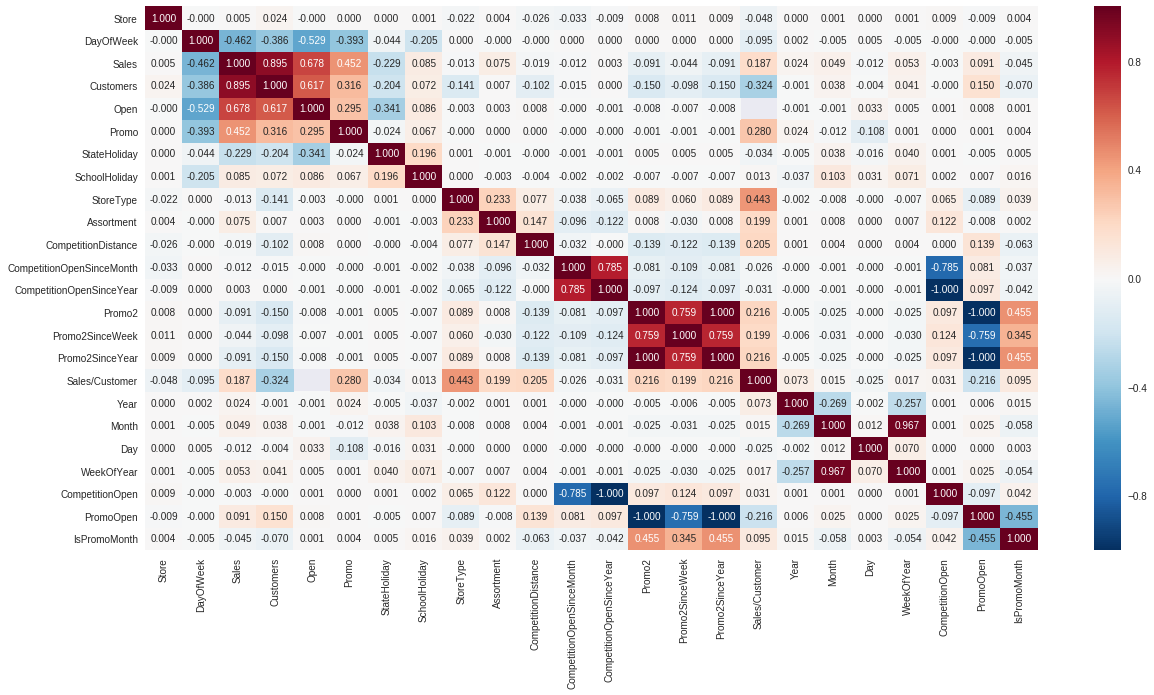

In [0]:
plt.figure(figsize = (20, 10))

sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

#**Part 3-Model Training  : **

## 1) Time Series Analysis       
Time-Series Analysis per Store Type

In Time Series, the data changes with the time. With an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

In [0]:
train2 = train2.set_index('Date')

In [0]:
train2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,,9.482883,2015,7,31,31,82.0,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,,9.194139,2015,7,30,31,82.0,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,,9.143403,2015,7,29,31,82.0,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,,8.948214,2015,7,28,31,82.0,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,,9.970588,2015,7,27,31,82.0,24187.75,Jul,0


For Time Series Anlaysis , we consider one store from each store type a , b , c ,d

In [0]:
train2['Sales'] = train2['Sales'] * 1.0

In [0]:
sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

Lets plot the sales of each store on Weekly basis

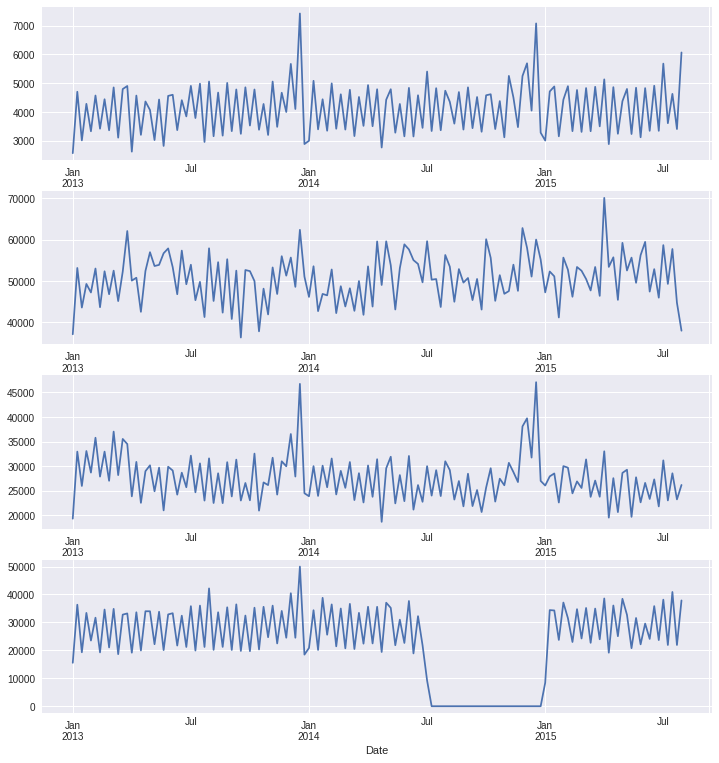

In [0]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

**Stationarity of Time Series**

Lets check the stationarity through Dicky-Fulller and Rolling window technique:

We check the trend of sales for 1 store from each StoreType nd plot the data on Weekly basis,we can see that the trend is Stationary .i.e ;
Constant mean
Constant Variance,
Covariance changes with time

**Rolling:**
A rolling analysis of a time series model is often used to assess the model's stability over time.
When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time.

The window is rolled on Weekly basis , in which the average is taken on weekly basis Rolling Statistics is a visualization test , where we can compare the original data with the rolled data and check if the data is stationary or not

In [0]:
rollmean = sales_a.rolling(window=7).mean()
rollstd = sales_a.rolling(window=7).std()

The data is resampled on weekly basis and plotted

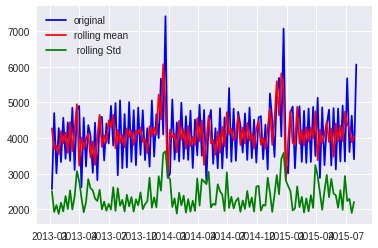

In [0]:
orig = plt.plot(sales_a.resample('W').mean(),color='blue',label='original')
roll_mean = plt.plot(rollmean.resample('W').mean(),color='red',label='rolling mean')
orig_std = plt.plot(rollstd.resample('W').mean(),color='green',label=' rolling Std')
plt.legend(loc='best')
plt.show(block=False)

**Dicky - Fuller test**
It is the test which essentially provides the details whether the Null hypothesis(Data is not stationary) should be rejected against alternate hypothesis(Data is stationary)
It gives the Statistical measures explaining the ADF-Statistics value which should be less than the critical values we accept / reject the null hypothesis based on the p-value
p-value < 0.5 indicates that the null hypothesis should be rejected

Thus from our data it is clear that our data is stationary and doesnot change heavily with time.

**The Akaike information criterion (AIC) :**
It is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

ADF statistics should be less than the critical interval

In [0]:
from statsmodels.tsa.stattools import adfuller
def stationary_check(sales):
  result = adfuller(sales,autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	   print(key, value)


In [0]:
stationary_check(sales_a)
stationary_check(sales_b)
stationary_check(sales_c)
stationary_check(sales_d)

ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


If the test statistic is less than the critical value, we fail to reject the null hypothesis and we say series is stationary

If Time is Series is not Stationary

Below are the steps that can be performed to make a timeseries stationary

Take the log of data(Sales)
Calcualte Moving Avergae = Log of data - Rolling value of log data
Calculate weighted avergate = log of data - exponential of log data

**Decomposition Plots :**

Now lets plot the decomposition which shows the trend, Seasonality and residuals in sales for each store Type

In [0]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid



    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

    plt.title('Decomposition for StoreType')

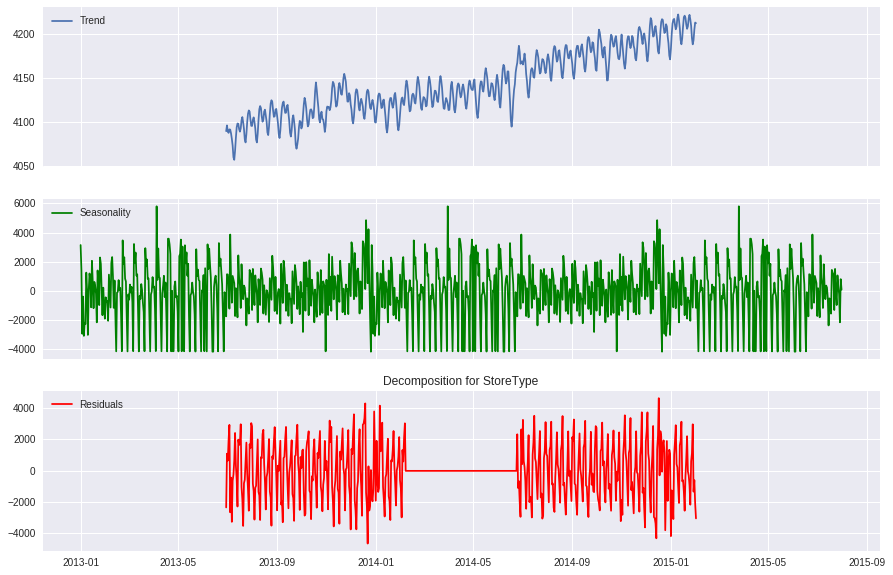

In [0]:
plot_timeseries(sales_a,'a')

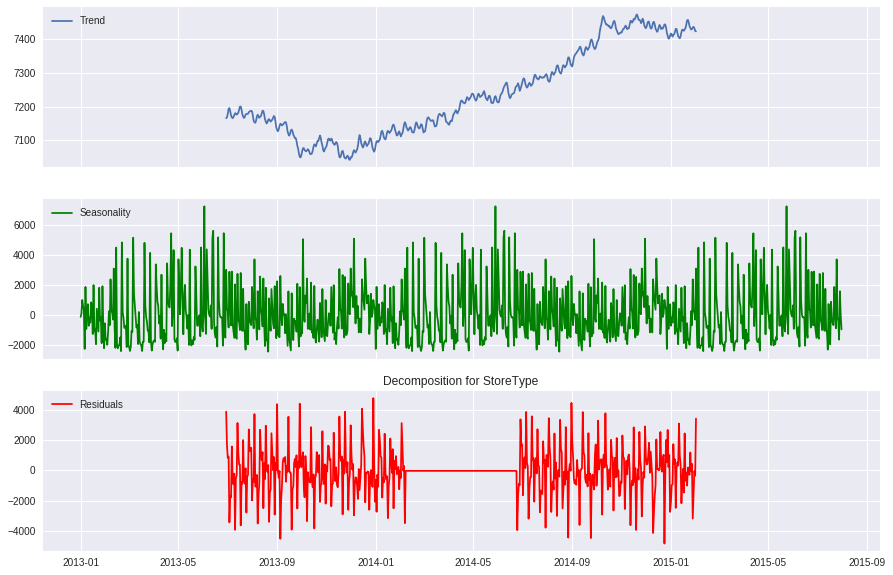

In [0]:
plot_timeseries(sales_b,'b')

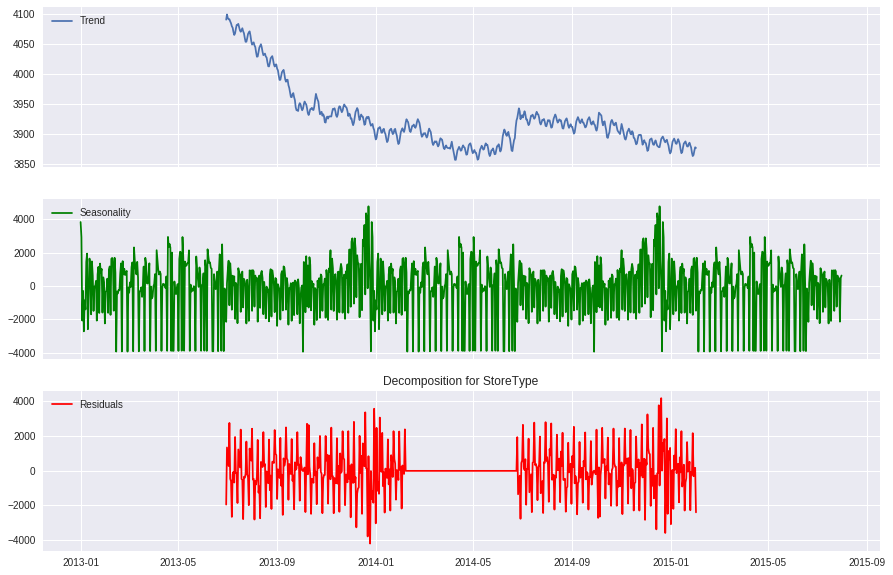

In [0]:
plot_timeseries(sales_c,'c')

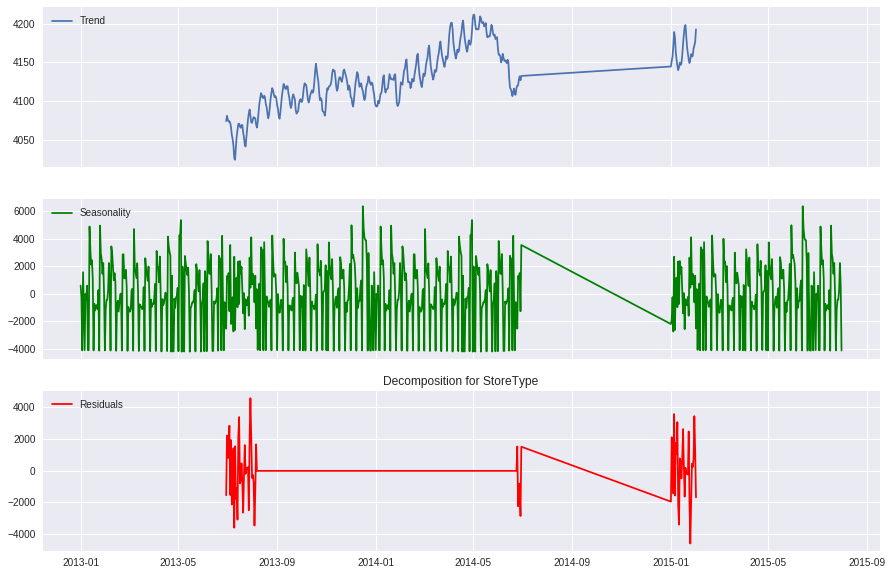

In [0]:
plot_timeseries(sales_d,'d')

**Autocorrelation :**
Autocorrelation, also known as serial correlation or cross-autocorrelation, is the cross-correlation of a signal with itself at different points in time. It is the correlation between values of the process at different times. Informally, it is the similarity between observations as a function of the time lag between them. It is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise.

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

**Autocorrelation Function (ACF) :**
ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

**Partial Autocorrelation Function (PACF) :**
PACF measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [0]:
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

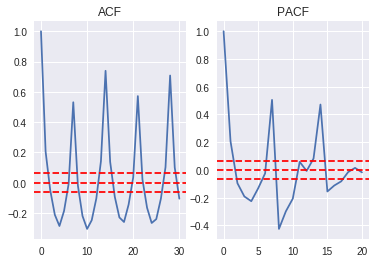

In [0]:
auto_corr(sales_a)


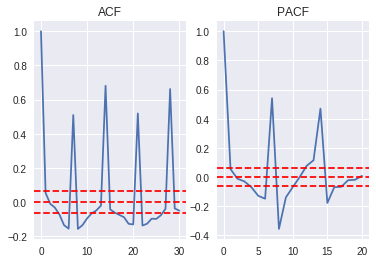

In [0]:
auto_corr(sales_b)

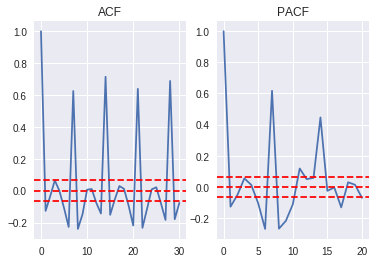

In [0]:
auto_corr(sales_c)

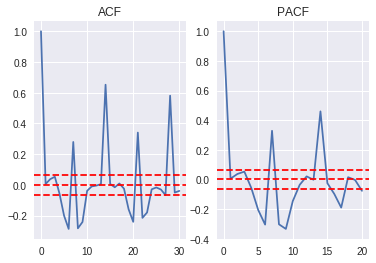

In [0]:
auto_corr(sales_d)

We can calculate P , Q values for our Arima model from the above graphs:

The point where our graph touches 0 for ACF graph is Q ---> 2

The point where our graph touches 0 for PACF graph is P ---> 2

Since th above ACF and PACF plots shows that the values of Q and P should be 2,3 respectively , Lets do a grid search and test the AIC for each model to select the best p , d ,q parametes. The model having lowest AIC determines an accurate performance. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

*Arima Model *(Autoregressive Indegrated Moving Average) determines the forecast of Sales data

We have to decide the p,d,q for the arima model to fit the data to get the proper prediction:

p(Auto Regression) as the name suggests , it determines the effect of previous sales on the current sale.It takes into consideration the effect of previous sale.
It is represented by :
Y_{t} = c + ph1(1)Y_{t-1} + phi_{2}Y_{t-2} + ...... + phi_{p}Y_{t-p} + e_{t}

p =1 ,determines that the effect of previous month has been taken.
ph1 determines the variable (Sales) for which we are lagging sales_value by 1.
Auto Regression model of order 1 i.e. p=1 or ARIMA(1,0,0) is represented by the following regression equation
Y_{t} = c + ph1(1)Y_{t-1}

d = determines the diffrence taken between original series and the lagged series to achieve the stationarity.
d = 0 , determins that the series was already stationary.
d = 1 , determines that the series was subtracted from its lagged series to attain stationary
Auto Regression model of order 1 i.e. d=1 or ARIMA(0,1,0) is represented by the following regression equation
y(t_new) = y(t) - y(t-1)

q(Moving Average) = extract the influence of the previous period’s error terms on the current period’s error
MA model of order 1 i.e. q=1 or ARIMA(0,0,1) is represented by the following regression equation
Y_{t} = c + e_t + theta_{1}e_{t-1}

Δyt=c+ϕ1Δyt−1+θ1ϵt−1+ϵt

In [0]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
def sample(sales):
  return(sales.resample('MS').mean())

In [0]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [0]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
#   ex = train2.loc[train2['Store'] == i]
#   ex.drop(['Open','PromoInterval','monthStr','Customers'],axis=1,inplace =True)
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [0]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [0]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

Function to define the Arima model for each Store type 
The function will consider the Sales data as well as external factors that are effecting the sales price of the stores.

The order parameter (p,q,d) for each Sales store type is selected after a lot of test and trial

After model training the predictions are performed for the 1st Jan - 2015 to 1st July 2015 of the train data.

The plots are created to check the accuracy of prediction of the actual vs predicted sales values by the model for each store type

In [0]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    ## -----------------------predictions-------------------
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

   ##------------------------plot-----------------------------
    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_forecasted = pred.predicted_mean
    y_truth = y_sale['2015-01-01':'2015-07-01']

   ##-------------Compute the mean square error----------------
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_forecasted/y_truth) ** 2))
    return results , mse,rmse,rmspe

Prediction for Sales Store Type A

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


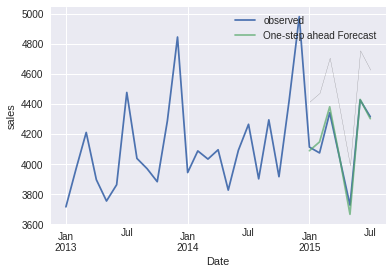

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 0, 0, 12)   Log Likelihood                 -79.214
Date:                            Mon, 04 Mar 2019   AIC                            184.428
Time:                                    19:02:36   BIC                            203.069
Sample:                                01-01-2013   HQIC                           190.504
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019   3.56e+06  -5.44e-10      1.000   -6.98e+06    6.98e+06
Customers      8.9071    143.987   

In [0]:
or_a = (5,1,3)
sord_a=(1, 0, 0, 12)
result_a,mse_a,rmse_a,rmspe_a= arima(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))


Prediction for Sales Store Type B

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


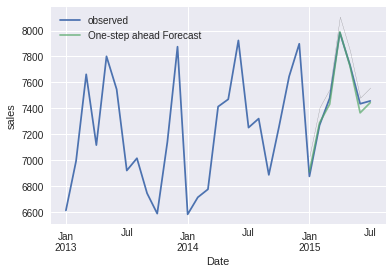

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(3, 2, 3)x(1, 0, 0, 12)   Log Likelihood                 -79.186
Date:                            Mon, 04 Mar 2019   AIC                            180.373
Time:                                    19:02:48   BIC                            196.146
Sample:                                01-01-2013   HQIC                           185.514
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201   1.89e+04   1.06e-06      1.000   -3.71e+04    3.71e+04
Customers      7.0233      1.222   

In [0]:
or_b = (3,2,3)
sord_b=(1, 0, 0, 12)
result_b,mse_b,rmse_b,rmspe_b= arima(y_sale_model_b,exog_b,or_b,sord_b)
print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_b, 2)))

Prediction for Sales Store Type C

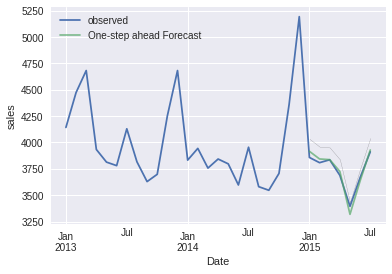

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 12)   Log Likelihood                 -90.316
Date:                            Mon, 04 Mar 2019   AIC                            198.633
Time:                                    19:02:51   BIC                            211.539
Sample:                                01-01-2013   HQIC                           202.840
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0977   4316.008  -2.26e-05      1.000   -8459.319    8459.123
Customers      9.2331      0.798   

In [0]:
or_c = (2,1,2)
sord_c=(1, 0, 0, 12)
result_c,mse_c,rmse_c,rmspe_c= arima(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

I tried various combination of p,q,d in SARIMAX model and couldnot achieve  RMPSE less than 1 , therefore I moved to XGBoost model to improve my model accuracy

##2)XGBoost

Now lets split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)

In [0]:
train_xg = df_train_store.sort_values(['Date'],ascending = False)
ho_test = df_train_store[:6*7*1115]
ho_train = df_train_store[6*7*1115:]

We will consider only data of Sales>0 and Open is 1

In [0]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

Create the training and testing dataset 

We will drop the features of not help

In [0]:
ho_train.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
xtest =df_test_store.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

Create Features and Label data for Test and Train

In [0]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

Create a function to calculate Rmse and RMPSe

In [0]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

Create a evaluation list having training and testing set which will cause the XGBOOst evaluate both the sets during running .


In [0]:
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

Hyperparameter tunning is done with the important parameters.

XGBoost is run for 6000 itertion and habe an early stopping round of 100.

Validation is done of the tarined model and RMPSE is displayed as sonn as the below function ends.

In [0]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 6000           #countinue for 6000 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:8.02222	eval-rmse:7.99026	train-rmspe:0.99981	eval-rmspe:0.999808
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.7816	eval-rmse:7.75054	train-rmspe:0.999714	eval-rmspe:0.999711
[2]	train-rmse:7.5483	eval-rmse:7.51864	train-rmspe:0.999596	eval-rmspe:0.999592
[3]	train-rmse:7.32228	eval-rmse:7.29273	train-rmspe:0.999451	eval-rmspe:0.999445
[4]	train-rmse:7.10302	eval-rmse:7.07409	train-rmspe:0.999276	eval-rmspe:0.999267
[5]	train-rmse:6.89034	eval-rmse:6.86121	train-rmspe:0.999065	eval-rmspe:0.999053
[6]	train-rmse:6.68409	eval-rmse:6.65622	train-rmspe:0.998814	eval-rmspe:0.998798
[7]	train-rmse:6.48361	eval-rmse:6.45658	train-rmspe:0.998519	eval-rmspe:0.9985
[8]	train-rmse:6.28915	eval-rmse:6.26293	train-rmspe:0.998173	eval-rmspe:0.99815
[9]	train-rmse:6.10051	eval-rmse:6.07509	train-rmspe:0.997768	eval-rmspe:0.997739
[10]	train-rmse:5.

In [0]:
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.024578


In [0]:
df_predict = pd.DataFrame(yhat)
df_predict.head()

,0
0,8.581863
1,8.532787
2,8.493199
3,8.535507
4,8.725084


Create a new dataframe having actual , predicted values , ratio , error and weight 

In [0]:
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,555,1,0,1,3,1,1270.0,9.0,...,31,31,82.0,24187.75,0,8.568646,8.581863,1.001542,0.001542,0.998460
1,1,3,546,1,0,1,3,1,1270.0,9.0,...,30,31,82.0,24187.75,0,8.521384,8.532787,1.001338,0.001338,0.998664
2,1,2,523,1,0,1,3,1,1270.0,9.0,...,29,31,82.0,24187.75,0,8.472823,8.493199,1.002405,0.002405,0.997601
3,1,1,560,1,0,1,3,1,1270.0,9.0,...,28,31,82.0,24187.75,0,8.519590,8.535507,1.001868,0.001868,0.998135
4,1,0,612,1,0,1,3,1,1270.0,9.0,...,27,31,82.0,24187.75,0,8.716536,8.725084,1.000981,0.000981,0.999020


Check the worst 10 samples

In [0]:
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
27666,30,0,93,0,0,0,1,1,40.0,2.0,...,11,7,0.0,0.00,0,6.418365,6.576033,1.024565,0.024565,0.976024
33285,37,5,973,0,0,0,3,1,4230.0,12.0,...,11,41,0.0,24178.25,0,8.979165,8.866532,0.987456,0.012544,1.012703
33166,37,5,911,0,0,0,3,1,4230.0,12.0,...,7,6,2.0,24181.50,0,8.877382,8.767436,0.987615,0.012385,1.012540
33789,37,5,980,0,0,0,3,1,4230.0,12.0,...,25,21,0.0,24161.25,0,8.979920,8.869029,0.987651,0.012349,1.012503
33054,37,5,1000,0,0,0,3,1,4230.0,12.0,...,30,22,5.0,24185.50,0,9.080915,8.968984,0.987674,0.012326,1.012480
33796,37,5,1085,0,0,0,3,1,4230.0,12.0,...,18,20,0.0,24161.00,0,9.084777,8.973142,0.987712,0.012288,1.012441
9664,11,5,1802,0,0,0,1,3,960.0,11.0,...,29,48,36.0,35.75,0,9.579280,9.462360,0.987795,0.012205,1.012356
33635,37,5,927,0,0,0,3,1,4230.0,12.0,...,26,43,0.0,24166.75,0,8.859505,8.751524,0.987812,0.012188,1.012339
33649,37,5,1050,0,0,0,3,1,4230.0,12.0,...,12,41,0.0,24166.25,0,9.045584,8.935405,0.987820,0.012180,1.012331
33075,37,5,990,0,0,0,3,1,4230.0,12.0,...,9,19,5.0,24184.75,0,9.084210,8.973604,0.987824,0.012176,1.012326


XGBoost model uses boosting technique to boost the weak learners and updates the weights to improve the model predictions.

Lets do some correction of the weights to improve our RMPSE score.

It can be seen that weight 0.995 gives 0.112 RMSe

weight correction
RMSPE for 0.990:0.088671
RMSPE for 0.991:0.080996
RMSPE for 0.992:0.073328
RMSPE for 0.993:0.065694
RMSPE for 0.994:0.058138
RMSPE for 0.995:0.050730
RMSPE for 0.996:0.043585
RMSPE for 0.997:0.036905
RMSPE for 0.998:0.031053
RMSPE for 0.999:0.026653
RMSPE for 1.000:0.024578
RMSPE for 1.001:0.025483
RMSPE for 1.002:0.029158
RMSPE for 1.003:0.034796
RMSPE for 1.004:0.041656
RMSPE for 1.005:0.049274
RMSPE for 1.006:0.057386
RMSPE for 1.007:0.065842
RMSPE for 1.008:0.074559
RMSPE for 1.009:0.083479
Best weight for Score:1.0    0.024578
dtype: float64


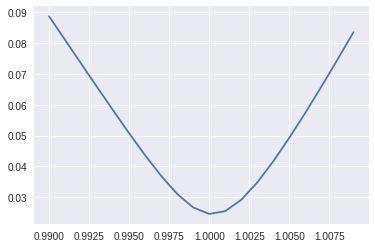

In [0]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [0]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']

In [0]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


In [0]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.014992


In [0]:
df_test_store.drop(['Id'],axis=1,inplace=True)

#**Conclusion**

By performing various iterations on XGBoost with different features 

XGBoost with 6000 iterations gave an RMSE of 0.0246 which is in top 10% of Kaggle competition

#Contributions statement
Time Series Analysis using SARIMAX             
XGBoost hyper parameter tunning


#Citations

https://www.kaggle.com/c/rossmann-store-sales/leaderboard                           
https://www.kaggle.com/elenapetrova/kernels                               
https://github.com/elena-petrova/rossmann_TSA_forecasts/blob/master/Rossmann_Sales.ipynb     
https://www.youtube.com/watch?v=e8Yw4alG16Q



# License
MIT License https://opensource.org/licenses/MIT